# Classificação de Imagens Usando Modelos de Redes Neurais Convolucionais com PyTorch




### **Objetivo**

O objetivo deste projeto é introduzir o uso de redes neurais para classificação de imagens. Esse projeto explora três abordagens:

1. Treinamento de uma rede do zero.
2. Uso de uma rede pré-treinada sem fine-tuning.
3. Fine-tuning de uma rede pré-treinada.

### **Modelos e Dataset:**

* O dataset utilizado é o [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)

* O modelo utilizado é: [ResNet](https://pytorch.org/vision/main/models/resnet.html)

### **Estrutura do Projeto**

1. Download do dataset
2. Plotagem de imagens que serão usadas
3. Modelos, criterios e otimizadores das redes
4. Treino das redes
5. Plotagem das métricas de avaliação das redes

# 1. Download do dataset

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
from tqdm import tqdm

Importando as bibliotecas usada no projeto:

* [os](https://docs.python.org/3/library/os.html): Biblioteca para interagir com o sistema operacional (manipulação de arquivos e diretórios).
* [torch](https://pytorch.org/docs/stable/index.html): Usado para construir e treinar redes neurais, fornecendo operações de tensores, autograd e otimização para aprendizado profundo.
* [torch.nn](https://pytorch.org/docs/stable/nn.html): Submódulo do PyTorch que contém camadas, funções de ativação, e perda, facilitando a criação de arquiteturas de redes neurais.
* [torch.optim](https://pytorch.org/docs/stable/optim.html): Oferece uma série de algoritmos de otimização, como SGD e Adam, para atualizar os pesos das redes neurais durante o treinamento.
* [torchvision](https://pytorch.org/vision/stable/index.html): Contém utilitários para processamento de dados de visão computacional, incluindo transformações de imagens, datasets como CIFAR-10 e modelos pré-treinados.
* [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html): Fornece uma coleção de transformações para realizar operações de pré-processamento de imagens, como redimensionamento, normalização e rotação.
* [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics): Oferece funções para calcular métricas de avaliação como acurácia, precisão, recall e F1-score, usadas para medir a performance do modelo.
* [seaborn](https://seaborn.pydata.org/index.html): Biblioteca para visualização de dados que facilita a criação de gráficos estatísticos atrativos e informativos.
* [matplotlib.pyplot](https://matplotlib.org/stable/users/index.html): Biblioteca usada para criar gráficos, permitindo visualização de dados e resultados de forma intuitiva.
* [numpy](https://numpy.org/doc/stable/): Biblioteca fundamental para computação científica em Python, usada para realizar operações eficientes com arrays e manipulação de dados numéricos.
* [tqdm](https://tqdm.github.io/): Biblioteca que fornece uma barra de progresso em loops, facilitando o monitoramento de processos demorados, como o treinamento de redes neurais.

In [6]:
# Verifica se uma GPU está disponível
if torch.cuda.is_available():
    device = torch.device("cuda")  # Usar GPU
    print("Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Usar CPU
    print("Usando CPU")

Usando CPU


Processo que verifica se o uso de GPU está disponível para o treinamento do modelo.

In [7]:
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
batch_size_train = 128
batch_size_test = 256

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #expande e realiza um corte na imagem
    transforms.RandomHorizontalFlip(), # Realiza um flip horizontal aleatório na imagem (espelhamento em torno do eixo vertical).
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

transform_test = transforms.Compose([
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

# carregando os dados de treino
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size_train, shuffle=True, num_workers=8)

# carregando os dados de teste
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size_test, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


Download do dataset e definição de como os dados serão carregados e transformados.

1. Normalização:
  * mean: Definição de valor médio para cada canal de cor (R, G, B) das imagens.
  * std: Desvio padrão.

2. Tamnho dos lotes de dados:
  * batch_size: Define o tamanho do lote de dados (imagens), ou seja, quantas imagens serão processadas por vez (época).

3. Transformação para os dados de treino:
  * RandomCrop: Aplica um corte aleatório de tamanho 32x32 na imagem, com um preenchimento (padding) de 4 pixels ao redor da imagem original.
  * RandomHorizontalFlip: Faz um espelhamento horizontal aleatório, permitindo que a rede veja variações da imagem durante o treinamento (data augmentation).
  * ToTensor: Converte a imagem de um array NumPy para um tensor do PyTorch, que é o formato usado pela rede neural.
  * Normalize: Normaliza os valores dos pixels da imagem para que eles tenham média 0.5 e desvio padrão 0.5, o que ajuda a estabilizar o treinamento.

  São usados parametros diferentes no transforms, pois o **treino** do modelo tem a necessidade de ver variações diferentes das imagens para não criar um hábito de vício durante o treinamento, já o **teste**, recebe parametros iguais para estabilizar e dar precisão ao modelo.

4. Carregando o dataset:
  * set: Carrega o dataset CIFAR-10. Baixando e salvando na pasta './data'
  * loader: misturando (shuffle) as imagens a cada época. O parâmetro 'num_workers' define o número de processos paralelos para carregar os dados.

# 2. Plotagem de imagens que serão usadas

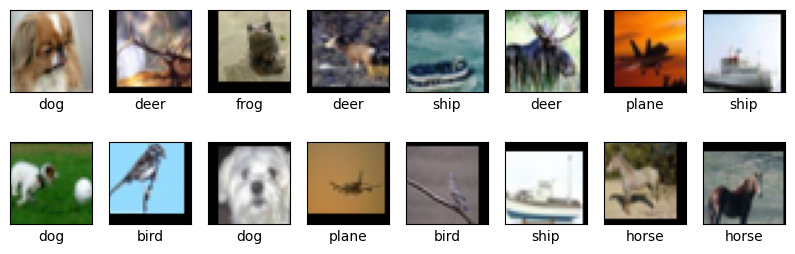

In [8]:
# Função para desfazer a normalização
def unnormalize(img, mean, std):
    img = img.clone()  # Faz uma cópia do tensor para evitar mudanças na imagem original
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # desfaz normalização: (img * std) + mean
    return img

# Obtendo imagens de treinamento aleatórias
dataiter = iter(trainloader)  # iterador para o DataLoader
images, labels = next(dataiter)  # obter um batch de imagens e rótulos

# Definir as classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualizando algumas das imagens do dataset de treino
plt.figure(figsize=[10, 10])
for i in range(16):  # para as primeiras 16 imagens
    plt.subplot(6, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Permutar a imagem de (3, 32, 32) para (32, 32, 3)
    img = unnormalize(images[i], mean, std).permute(1, 2, 0)
    
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(classes[labels[i].item()])

plt.show()

Mostra as primeiras 16 imagens do conjunto de imagens de treino, além do nome da classe em que ela está classificada.

# 3. Modelos, criterios e otimizadores das redes

## Treinamento de uma rede do zero

In [9]:
model_zero = torchvision.models.resnet18(weights=None)  # Treinamento do zero
model_zero.fc = nn.Linear(model_zero.fc.in_features, 10)  # Modifica a última camada para 10 classes

O parametro 'weights=None' faz com que o modelo não tenha pesos e sejá treinado do zero.

## Uso de uma rede pré-treinada sem fine-tuning

In [10]:
model_no_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)  # Rede pré-treinada

for param in model_no_ft.parameters():
    param.requires_grad = False  # Congelar as camadas

model_no_ft.fc = nn.Linear(model_no_ft.fc.in_features, 10)  # Modifica a última camada para 10 classes

## Fine-tuning de uma rede pré-treinada

In [11]:
# Não congela as camadas, permitindo o fine-tuning de toda a rede
model_on_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) #ResNet18 já pré-treinada
model_on_ft.fc = nn.Linear(model_on_ft.fc.in_features, 10) # Modifica a última camada para 10 classes (CIFAR-10)

Os pesos dos modelos pré-treinados são do dataset [IMAGENET]().

## Criterion e optimizer

In [12]:
criterion = nn.CrossEntropyLoss() # loss funciton

A variável criterion define a loss function que será usada para o treino do modelo.

In [13]:
optimizer_zero = optim.Adam(model_zero.parameters(), lr=0.001) # modelo otimizador

In [14]:
optimizer_no_ft = optim.Adam(model_no_ft.parameters(), lr=0.001) # modelo otimizador

In [15]:
optimizer_on_ft = optim.Adam(model_on_ft.parameters(), lr=0.001) # modelo otimizador

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html): modelo de otimização.
* lr (learning rate): taxa de aprendizado do otimizador. Quanto maior, mais rápido e menos preciso.

# 4. Treino das redes

In [16]:
def treino_modelo(modelo, otimizador, epocas):
    modelo.train()  # coloca o modelo em modo de treinamento
    history = {'train_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

    for epoch in range(epocas):
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        # Loop de treino por batch
        for inputs, labels in tqdm(trainloader):
            otimizador.zero_grad()  # zera os gradientes acumulados

            outputs = modelo(inputs)  # forward pass: obtem as predições
            loss = criterion(outputs, labels)  # calcula a perda
            loss.backward()  # backward pass: calcula os gradientes
            otimizador.step()  # atualiza os pesos

            running_loss += loss.item()  # acumula a perda

            # Armazena os rótulos e predições para calcular métricas
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calcula a perda média na época
        epoch_loss = running_loss / len(trainloader)
        history['train_loss'].append(epoch_loss)

        # Calcula as métricas de acurácia, precisão, recall e F1-Score
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        # Armazena as métricas
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1_score'].append(f1)

        print(f'Epoch [{epoch + 1}/{epocas}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    return history

Explicação:
* num_epochs: Número de épocas define quantas vezes o modelo verá todo o dataset de treinamento.
* model.train(): Coloca o modelo no modo de treinamento, permitindo que os gradientes sejam calculados e os pesos atualizados.
* optimizer.zero_grad(): Zera os gradientes antes de cada iteração, para que eles não sejam acumulados.
* outputs = model(inputs): Passa as imagens através da rede para gerar predições.
* loss.backward(): Calcula os gradientes da função de perda em relação aos pesos.
* optimizer.step(): Atualiza os pesos da rede com base nos gradientes calculados.

## Treino rede do zero

In [17]:
history_zero = treino_modelo(model_zero, optimizer_zero, 2)

100%|██████████| 391/391 [05:46<00:00,  1.13it/s]


Epoch [1/2] - Loss: 1.5705, Accuracy: 0.4255, Precision: 0.4206, Recall: 0.4255, F1-Score: 0.4220


100%|██████████| 391/391 [05:49<00:00,  1.12it/s]


Epoch [2/2] - Loss: 1.1885, Accuracy: 0.5720, Precision: 0.5691, Recall: 0.5720, F1-Score: 0.5703


#### Salvando os pesos do modelo treinado do zero.

In [23]:
# Caminho para o diretório atual
diretorio_atual = os.getcwd()

# Diretório pai
diretorio_pai = os.path.dirname(diretorio_atual)

# Construindo o caminho
pasta_modelos = os.path.join(diretorio_pai, 'models_weights')

# Salvar os pesos do modelo na pasta
caminho_pesos = os.path.join(pasta_modelos, 'resnet18_weigths.pth')
torch.save(model_zero.state_dict(), caminho_pesos)

## Treino rede sem fine_turning

In [24]:
history_no_ft = treino_modelo(model_no_ft, optimizer_no_ft, 2)

100%|██████████| 391/391 [01:12<00:00,  5.37it/s]


Epoch [1/2] - Loss: 1.8560, Accuracy: 0.3464, Precision: 0.3436, Recall: 0.3464, F1-Score: 0.3445


100%|██████████| 391/391 [01:11<00:00,  5.44it/s]


Epoch [2/2] - Loss: 1.7202, Accuracy: 0.3986, Precision: 0.3957, Recall: 0.3986, F1-Score: 0.3963


## Treino rede com fine-turning

In [25]:
history_on_ft = treino_modelo(model_on_ft, optimizer_on_ft, 2)

100%|██████████| 391/391 [05:45<00:00,  1.13it/s]


Epoch [1/2] - Loss: 1.0285, Accuracy: 0.6453, Precision: 0.6445, Recall: 0.6453, F1-Score: 0.6448


100%|██████████| 391/391 [05:41<00:00,  1.14it/s]

Epoch [2/2] - Loss: 0.7401, Accuracy: 0.7471, Precision: 0.7460, Recall: 0.7471, F1-Score: 0.7464


# 5. Plotagem das métricas de avaliação das redes

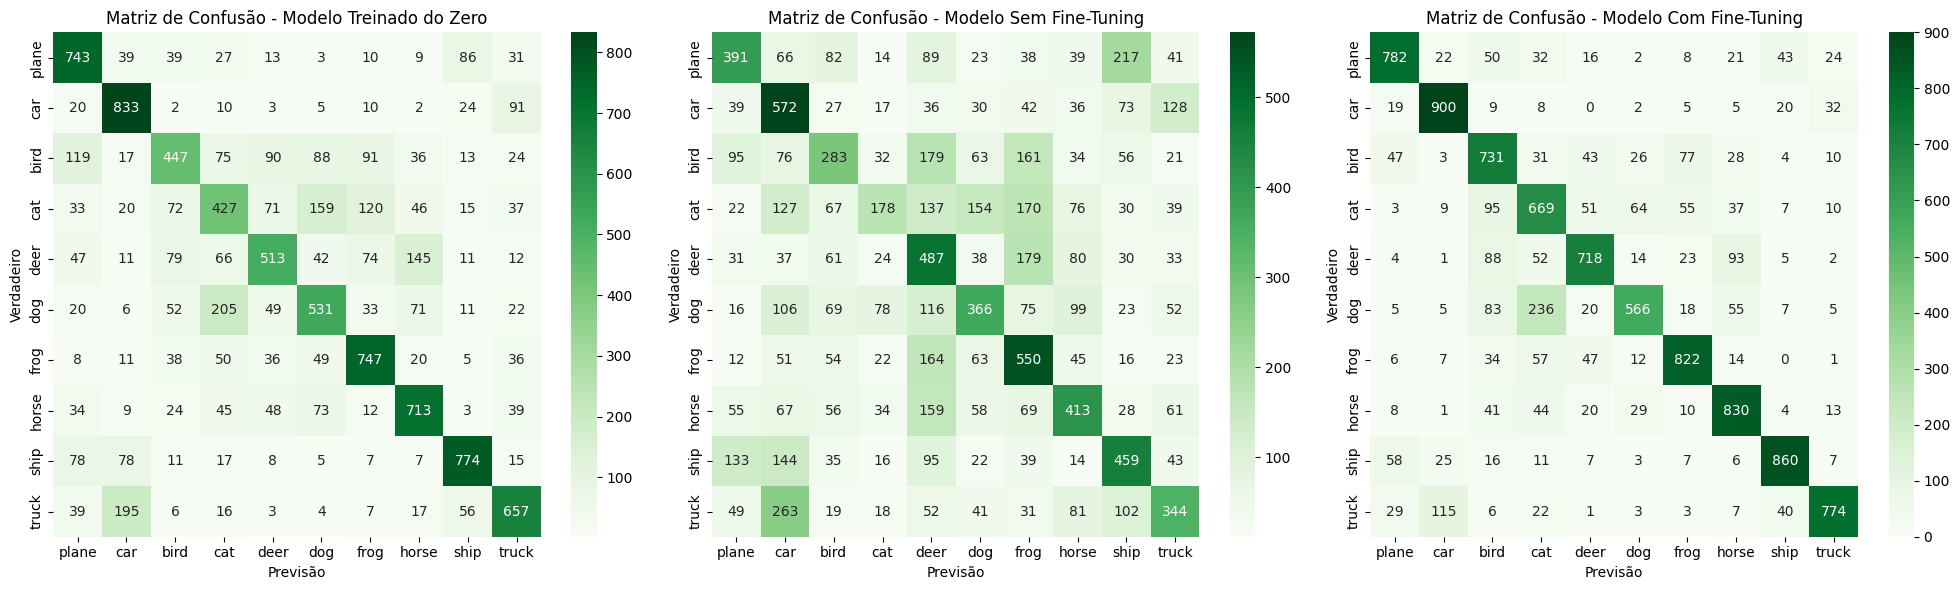

In [28]:
def matriz_confusao_modelo(modelo, titulo_grafico, ax):
    # Inicializar listas para armazenar labels verdadeiros e previsões
    all_labels = []
    all_predictions = []

    # Avaliar o modelo e coletar as previsões
    with torch.no_grad():  # Desativa o cálculo de gradientes durante a avaliação
        for images, labels in testloader:
            outputs = modelo(images)
            _, predictions = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())  # Coletar rótulos reais
            all_predictions.extend(predictions.cpu().numpy())  # Coletar previsões

    # Gerar matriz de confusão
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Plotar a matriz de confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', ax=ax, xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Previsão')
    ax.set_ylabel('Verdadeiro')
    ax.set_title('Matriz de Confusão - ' + titulo_grafico)

# Criar a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # 1 linha e 3 colunas

# Chamando a função para os três modelos treinados
matriz_confusao_modelo(model_zero, 'Modelo Treinado do Zero', axs[0])
matriz_confusao_modelo(model_no_ft, 'Modelo Sem Fine-Tuning', axs[1])
matriz_confusao_modelo(model_on_ft, 'Modelo Com Fine-Tuning', axs[2])

# Ajustar o layout dos gráficos para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()


- **Precisão(Precision)**: Indica a proporção de previsões corretas entre as classes. Por exemplo, se você tiver uma precisão de 0,80 para a classe 0, isso significa que 80% das previsões feitas para essa classe foram corretas.

$$\text{Precision} = \frac{TP}{TP + FP}$$


- **Revocação(Recall)**: Indica a proporção de verdadeiros positivos entre todos os exemplos positivos. Se você tiver uma revocação de 0,75 para a classe 1, isso significa que 75% dos exemplos positivos para essa classe foram corretamente identificados.

$$\text{Recall} = \frac{TP}{TP + FN}$$


- **F1-Score**: A média harmônica entre precisão e revocação. É especialmente útil quando você tem classes desbalanceadas.

$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$


- **Acurácia (Accuracy)**: A proporção de previsões corretas entre todas as previsões feitas.

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$


Onde:
- $(TP) = True Positives (Verdadeiros Positivos)$
- $(FN) = False Negatives (Falsos Negativos)$
- $(FP) = False Positives (Falsos Positivos)$

## Plotagem das métricas de desempenho

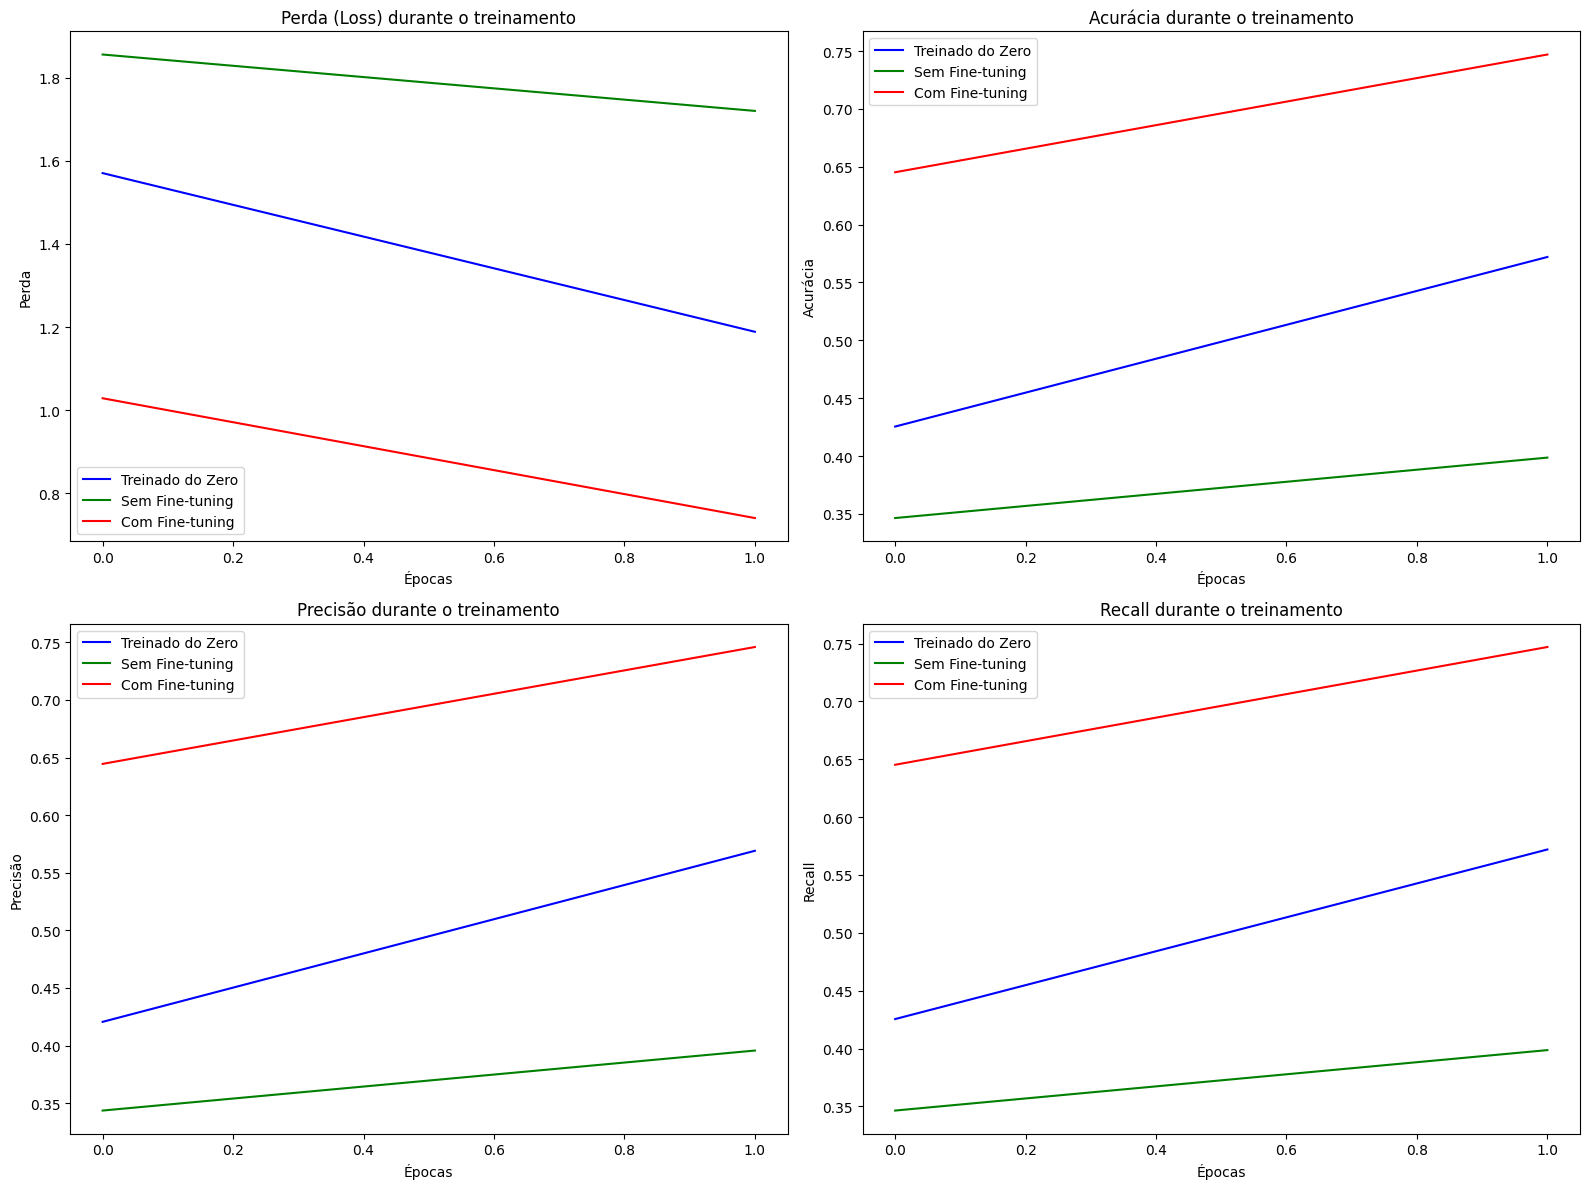

In [27]:
def plot_training_metrics(history_zero, history_no_ft, history_on_ft):
    plt.figure(figsize=(16, 12))
    
    # Plotando a Perda (Loss)
    plt.subplot(2, 2, 1)
    plt.plot(history_zero['train_loss'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['train_loss'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['train_loss'], color='red', label='Com Fine-tuning')
    plt.title('Perda (Loss) durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Plotando a Acurácia
    plt.subplot(2, 2, 2)
    plt.plot(history_zero['accuracy'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['accuracy'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['accuracy'], color='red', label='Com Fine-tuning')
    plt.title('Acurácia durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotando a Precisão (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(history_zero['precision'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['precision'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['precision'], color='red', label='Com Fine-tuning')
    plt.title('Precisão durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Plotando o Recall
    plt.subplot(2, 2, 4)
    plt.plot(history_zero['recall'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['recall'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['recall'], color='red', label='Com Fine-tuning')
    plt.title('Recall durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    # Ajuste o layout dos gráficos para evitar sobreposição
    plt.tight_layout()

    # Mostrar os gráficos
    plt.show()

# Chamando a função para plotar as métricas
plot_training_metrics(history_zero, history_no_ft, history_on_ft)
